# Template for Model training with wandb

This Template is used late for the trainging of the different models  
Please preregister on the homepage and provide the necessary API Key in the .env file  
Maybee using Sweeps could ease the process

In [4]:
!pip install dotenv
!pip install wandb
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 118.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 120.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 125.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.1 MB/s eta 0:00:00


In [5]:
# check the .env file 
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Get and print the WANDB_API_KEY
wandb_api_key = os.getenv("WANDB_API_KEY")
print(f"WANDB_API_KEY: [{wandb_api_key[:4]}...]")

WANDB_API_KEY: [69ca...]


In [6]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import keras
import random
import numpy as np

from pathlib import Path

2025-04-11 16:44:24.751603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744389864.769561    4503 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744389864.775027    4503 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744389864.788587    4503 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744389864.788603    4503 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744389864.788605    4503 computation_placer.cc:177] computation placer alr

## Init Project

In [ ]:
PROJECT_NAME = "DSPRO2_MAIZE"
RUN_NR = 1


# Start a run, tracking hyperparameters
run = wandb.init(
    # set the wandb project where this run will be logged
    project=PROJECT_NAME,

    # Subname of this RUN
    name = f"Model_1_{RUN_NR}",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 512,
        "activation_hidden": "relu",
        "dropout": random.uniform(0.01, 0.80),
        "layer_2": 10,
        "activation_output": "softmax",
        "optimizer": "sgd",
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 8,
        "batch_size": 256
    }
)




## Experiment Config

In [4]:
# (optional) use wandb.config as your config
config = wandb.config

from pprint import pprint

pprint(dict(config), indent=4)

NameError: name 'wandb' is not defined

In [ ]:
print(config.loss)              # as object (usual method)
print(config["loss"])           # as dict

## Creating a Model

In [ ]:
import keras

def get_model(config)->keras.Model:
    """ 
    Return a Model Based on the given Wandb config file
    Warning: Your config file needs to match this creation Method

    Parameters:
        config (Dict)   wandb config with all the required field for the model creation

    Returns:
        model (tf.model)    Tensorflow model
    """

    # build a model (read params from the config)
    model = keras.models.Sequential([
        keras.layers.Input(shape=(28,28)),
        keras.layers.Flatten(),
        keras.layers.Dense(config.layer_1, activation=config.activation_hidden),
        keras.layers.Dropout(config.dropout),
        keras.layers.Dense(config.layer_2, activation=config.activation_output)
        ])
    
    return model


model = get_model(config)
model.summary()

## Compile Model

In [ ]:
# compile the model (with the config)
model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric]
              )

## Getting the Data

In [ ]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, y_train = x_train[::5], y_train[::5]
x_test, y_test = x_test[::20], y_test[::20]
labels = [str(digit) for digit in range(np.max(y_train) + 1)]

Plot a Sample

In [ ]:
import matplotlib.pyplot as plt


# Display a sample image from the test set
idx = 0  # you can change the index to see a different sample

plt.imshow(x_test[idx], cmap='gray')
plt.title(f"True Label: {y_test[idx]}")
plt.axis('off')
plt.show()

## Training the Model

In [ ]:
# Set the directory and file name for saving the model checkpoint
checkpoint_filepath = f"./models/{PROJECT_NAME}_Model_1_best.keras"
Path("./models").mkdir(exist_ok=True)

# WandbMetricsLogger will log train and validation metrics to wandb
# WandbModelCheckpoint will upload model checkpoints to wandb
history = model.fit(x=x_train, y=y_train,
                    epochs=config.epoch,
                    batch_size=config.batch_size,
                    validation_data=(x_test, y_test),
                    callbacks=[
                      WandbMetricsLogger(log_freq=5),                   # link the metrics logger
                      WandbModelCheckpoint(checkpoint_filepath,         # link the model logger
                                           save_best_only=True)
                    ])

# -----------
# Local Saving
# -----------
# After training, explicitly LOCALLY  save the final model

final_model_filepath = f"./models/{PROJECT_NAME}_Model1_final.keras"
model.save(final_model_filepath)
print(f"Model saved to {final_model_filepath}")


# ----------------
# Save the Model online
# -------------
# Name of your Model Registry 
MODEL_REGISTRY = f"{PROJECT_NAME}_Models"

# what to save (local path)
model_artifact_path = Path(final_model_filepath)


ARTIFACT_NAME_1 = f"{PROJECT_NAME}_Model1_final.keras" # name of the artifact (has to be loaded with this)

# savibg file in project
artifact1 = run.log_artifact(
    model_artifact_path,
    name=ARTIFACT_NAME_1,    # name of the artifact (has to be loaded with this)
    type="model",
)

# Add Metadata Info describing this model
artifact1.metadata = {"model_architecture": "two-layer", "tags": ["baseline", "dense"]}

# Optionally, you can link the artifact to a model registry for better organization
run.link_artifact(
    artifact=artifact1,
    target_path=f"wandb-registry-model/{MODEL_REGISTRY}"     # Link the artifact (model) to the registry (with its own Artifact name)
)

# finish the wandb run, necessary in notebooks
wandb.finish()

## Testing area! 

In [ ]:
idx = 7      # selection of test sample
sample = x_test[idx] 

sample_input = sample.reshape((1,28,28))      # reshape to fit batch - format(1, 28, 28)

# Predict and extract the predicted digit
predictions = model.predict(sample_input)
predicted_label = np.argmax(predictions, axis=1)[0]

plt.imshow(sample, cmap='gray')
plt.title(f"Test Sample {idx:03}")
plt.axis('off')
plt.show()
print(f"Predicted Label: {predicted_label}")
print(f"True Label: {y_test[idx]}")

## Training a New Model in the Same Project

In [ ]:
RUN_NR = 1

# Initialize a new wandb run for Model 2
run = wandb.init(project=PROJECT_NAME,
                 name=f"Model_2_{RUN_NR}",
                 config={
                        "layer_1": 512,
                        "activation_1": "relu",
                        "layer_2": 256,
                        "activation_2": "relu",
                        "layer_3": 10,
                        "activation_3": "softmax",
                        "epoch": 5,
                        "batch_size": 32,
                        "dropout": 0.2,  
                        "optimizer": "sgd",
                        "loss": "sparse_categorical_crossentropy",
                        "metric": "accuracy",
                    })

config2 = wandb.config



In [ ]:
model2.compile(optimizer=config2.optimizer, loss=config2.loss, metrics=[config2.metric])

In [ ]:
RUN_NR = 1

# Set the directory and file name for LOCAL saving the model checkpoint
checkpoint_filepath2 = f"./models/{PROJECT_NAME}_Model2_best.keras"

# WandbMetricsLogger will log train and validation metrics to wandb
# WandbModelCheckpoint will upload model checkpoints to wandb
history = model.fit(x=x_train, y=y_train,
                    epochs=config.epoch,
                    batch_size=config.batch_size,
                    validation_data=(x_test, y_test),
                    callbacks=[
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint(checkpoint_filepath2,
                                           save_best_only=True)
                    ])

# -----------
# Local Saving
# -----------
# After training, explicitly LOCALLY  save the final model
final_model_filepath2 = f"./models/{PROJECT_NAME}_Model2_final.keras"
model.save(final_model_filepath2)
print(f"Model saved to {final_model_filepath2}")

# ----------------
# Save the Model online
# -------------
# what to save (local path)
model_artifact_path = Path(final_model_filepath2)

ARTIFACT_NAME_2 = f"{PROJECT_NAME}_Model2_final.keras"
# logging the file in the project
logged_artifact = run.log_artifact(
    model_artifact_path,
    name=ARTIFACT_NAME_2,
    type="model",
)

# Optionally, you can link the artifact to a model registry for better organization
# Name of your Model Registry 
MODEL_REGISTRY = f"{PROJECT_NAME}_Models"
run.link_artifact(
    artifact=logged_artifact,
    target_path=f"wandb-registry-model/{MODEL_REGISTRY}"
)

# finish the wandb run, necessary in notebooks
wandb.finish()

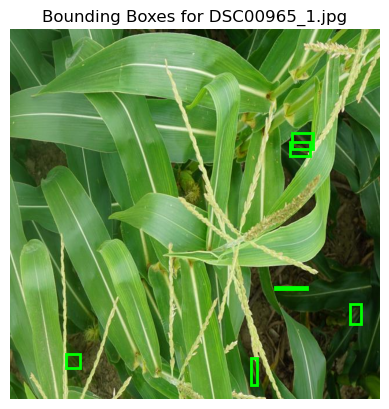

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# ⚙️ Konfiguration
img_dir = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/train"
label_dir = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/train"
filename = "DSC00965_1.jpg"  # 🔁 Ersetze durch ein Bild deiner Wahl

# 🖼 Bild laden
img_path = os.path.join(img_dir, filename)
img = Image.open(img_path)
w, h = img.size

# 📄 Label laden
label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))
with open(label_path, "r") as f:
    labels = f.readlines()

# 🎯 Zeichnen
fig, ax = plt.subplots()
ax.imshow(img)

for line in labels:
    parts = line.strip().split()
    if len(parts) != 5:
        continue
    _, x_center, y_center, width, height = map(float, parts)
    
    x = (x_center - width / 2) * w
    y = (y_center - height / 2) * h
    box_w = width * w
    box_h = height * h
    
    rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)

plt.title(f"Bounding Boxes for {filename}")
plt.axis("off")
plt.show()
